In [1]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from skopt.space import Real, Integer
from skopt.utils import use_named_args
import itertools
from skopt import gp_minimize

C:\Users\matt.winkler\AppData\Local\Continuum\miniconda3\envs\credit-default\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [3]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [74]:
# housing variables to add a flag whether applicant gave information:
housing = ['APARTMENTS_AVG','BASEMENTAREA_AVG','YEARS_BEGINEXPLUATATION_AVG',
           'YEARS_BUILD_AVG','COMMONAREA_AVG','ELEVATORS_AVG','ENTRANCES_AVG',
           'FLOORSMAX_AVG','FLOORSMIN_AVG','LANDAREA_AVG','LIVINGAPARTMENTS_AVG',
           'LIVINGAREA_AVG','NONLIVINGAPARTMENTS_AVG','NONLIVINGAREA_AVG',
           'APARTMENTS_MODE','BASEMENTAREA_MODE','YEARS_BEGINEXPLUATATION_MODE',
           'YEARS_BUILD_MODE','COMMONAREA_MODE','ELEVATORS_MODE','ENTRANCES_MODE',
           'FLOORSMAX_MODE','FLOORSMIN_MODE','LANDAREA_MODE','LIVINGAPARTMENTS_MODE',
           'LIVINGAREA_MODE','NONLIVINGAPARTMENTS_MODE','NONLIVINGAREA_MODE',
           'APARTMENTS_MEDI','BASEMENTAREA_MEDI','YEARS_BEGINEXPLUATATION_MEDI',
           'YEARS_BUILD_MEDI','COMMONAREA_MEDI','ELEVATORS_MEDI','ENTRANCES_MEDI',
           'FLOORSMAX_MEDI','FLOORSMIN_MEDI','LANDAREA_MEDI','LIVINGAPARTMENTS_MEDI',
           'LIVINGAREA_MEDI','NONLIVINGAPARTMENTS_MEDI','NONLIVINGAREA_MEDI',
           'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'TOTALAREA_MODE', 
           'WALLSMATERIAL_MODE','EMERGENCYSTATE_MODE']

In [101]:
# count the number of nulls by row in a subset of columns from a dataframe
def count_nulls_by_columns(df, cols):
    null_counts = df[cols].isnull().sum(axis=1)
    null_counts[((null_counts >= 1) & (null_counts < 45))] = 1
    null_counts[null_counts >= 45] = 2
    return null_counts

In [238]:
# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('../data/application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('../data/application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    #df = df[df['CODE_GENDER'] != 'XNA']
    
    null_counts = count_nulls_by_columns(df, housing)
    df['housing_null_count'] = null_counts
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
        
    #orgs = df[['ORGANIZATION_TYPE', 'TARGET']].groupby('ORGANIZATION_TYPE').mean()
    #print(orgs.sort_values(by='TARGET', ascending=False))
        
    types = df.dtypes
    for cat_feature in types.index[types == 'object']:
        df[cat_feature], uniques = pd.factorize(df[cat_feature])
    
    #print(df.dtypes)
    # Categorical features with One-Hot encode
    #df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    
    df['CREDIT_INCOME_PERC'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['REGION_INCOME_RATIO'] = df['AMT_INCOME_TOTAL'] /  df['REGION_POPULATION_RELATIVE']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['GOODS_TO_INCOME_RATIO'] = df['AMT_GOODS_PRICE'] / df['AMT_INCOME_TOTAL']
    df['ANNUITY_LENGTH'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
    df['CHILDREN_RATIO'] = df['CNT_CHILDREN'] / df['CNT_FAM_MEMBERS'] 
    df['CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
    df['INC_PER_CHLD'] = df['AMT_INCOME_TOTAL'] / (1 + df['CNT_CHILDREN'])
    df['SOURCES_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
    
    df['CAR_TO_BIRTH_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH']
    df['CAR_TO_EMPLOY_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']

    df['PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']
    df['PHONE_TO_EMPLOY_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_EMPLOYED']

    df['FAM_MEMBERS_TO_LIVINGAREA_AVG'] = df['CNT_FAM_MEMBERS'] / df['LIVINGAREA_AVG']
    df['FAM_MEMBERS_TO_NONLIVINGAREA_AVG'] = df['CNT_FAM_MEMBERS'] / df['NONLIVINGAREA_AVG']

    df['FAM_MEMBERS_TO_AGE'] = df['CNT_FAM_MEMBERS'] / df['DAYS_BIRTH']
    df['FAM_MEMBERS_TO_EXT_SOURCE_3'] = df['CNT_FAM_MEMBERS'] / df['EXT_SOURCE_3']
    df['FAM_MEMBERS_TO_EXT_SOURCE_2'] = df['CNT_FAM_MEMBERS'] / df['EXT_SOURCE_2']
    df['FAM_MEMBERS_TO_EXT_SOURCE_1'] = df['CNT_FAM_MEMBERS'] / df['EXT_SOURCE_1']
    
    df['CREDIT_TO_LIVINGAREA'] = df['AMT_CREDIT'] / df['LIVINGAREA_AVG']
    df['CREDIT_TO_LANDAREA'] =  df['AMT_CREDIT'] / df['LANDAREA_AVG']
    df['CREDIT_TO_TOTALAREA'] = df['AMT_CREDIT'] / df['TOTALAREA_MODE']
    df['CREDIT_TO_BASEMENTAREA'] = df['AMT_CREDIT'] / df['BASEMENTAREA_AVG']
    df['CREDIT_TO_EMPLOYED'] = df['AMT_CREDIT'] / df['DAYS_EMPLOYED']
    df['CREDIT_TO_FAM_MEMBERS'] = df['AMT_CREDIT'] / df['CNT_FAM_MEMBERS']
    df['CREDIT_TO_CHILDREN'] = df['AMT_CREDIT'] / (1 + df['CNT_CHILDREN'])
    
    df['CREDIT_TO_EXT_SOURCE_3'] = df['AMT_CREDIT'] / df['EXT_SOURCE_3']
    df['CREDIT_TO_EXT_SOURCE_2'] = df['AMT_CREDIT'] / df['EXT_SOURCE_2']
    df['CREDIT_TO_EXT_SOURCE_1'] = df['AMT_CREDIT'] / df['EXT_SOURCE_1']

    df['ANNUITY_TO_LIVINGAREA'] = df['AMT_ANNUITY'] / df['LIVINGAREA_AVG']
    df['ANNUITY_TO_LANDAREA'] =  df['AMT_ANNUITY'] / df['LANDAREA_AVG']
    df['ANNUITY_TO_TOTALAREA'] = df['AMT_ANNUITY'] / df['TOTALAREA_MODE']
    df['ANNUITY_TO_BASEMENTAREA'] = df['AMT_ANNUITY'] / df['BASEMENTAREA_AVG']
    df['ANNUITY_TO_EMPLOYED'] = df['AMT_ANNUITY'] / df['DAYS_EMPLOYED']
    df['ANNUITY_TO_FAM_MEMBERS'] = df['AMT_ANNUITY'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_TO_CHILDREN'] = df['AMT_ANNUITY'] / (1 + df['CNT_CHILDREN'])

    df['EXT_SOURCE_3_REGION'] = df['EXT_SOURCE_3'] / df['REGION_RATING_CLIENT']
    df['EXT_SOURCE_3_REGION_CITY'] = df['EXT_SOURCE_3'] / df['REGION_RATING_CLIENT_W_CITY']
    df['EXT_SOURCE_2_REGION'] = df['EXT_SOURCE_2'] / df['REGION_RATING_CLIENT']
    df['EXT_SOURCE_2_REGION_CITY'] = df['EXT_SOURCE_2'] / df['REGION_RATING_CLIENT_W_CITY']
    df['EXT_SOURCE_1_REGION'] = df['EXT_SOURCE_1'] / df['REGION_RATING_CLIENT']
    df['EXT_SOURCE_1_REGION_CITY'] = df['EXT_SOURCE_1'] / df['REGION_RATING_CLIENT_W_CITY']

    df['INCOME_TO_EXT_SOURCE_3'] = df['AMT_INCOME_TOTAL'] / df['EXT_SOURCE_3']
    df['INCOME_TO_EXT_SOURCE_2'] = df['AMT_INCOME_TOTAL'] / df['EXT_SOURCE_2']
    df['INCOME_TO_EXT_SOURCE_1'] = df['AMT_INCOME_TOTAL'] / df['EXT_SOURCE_1']
    df['INCOME_TO_REGION'] = df['AMT_INCOME_TOTAL'] / df['REGION_RATING_CLIENT']
    df['INCOME_TO_REGION_CITY'] = df['AMT_INCOME_TOTAL'] / df['REGION_RATING_CLIENT_W_CITY']

    del test_df
    gc.collect()
    return df

In [215]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('../data/bureau.csv', nrows = num_rows)
    bb = pd.read_csv('../data/bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    #for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    #for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    
    return bureau_agg

In [207]:
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('../data/previous_application.csv', nrows = num_rows)
    
    prev.loc[prev['NAME_PORTFOLIO'] == 'Cards', 'NAME_PORTFOLIO'] = 'Cars'
    
    #print(prev.groupby('NAME_CONTRACT_TYPE').size())
    
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['PREV_APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    prev['PREV_PAYMENT_RATE'] = prev['AMT_ANNUITY'] / prev['AMT_CREDIT']
    prev['PREV_DOWN_PAYMENT_PERC'] = prev['AMT_DOWN_PAYMENT'] / prev['AMT_CREDIT']
    prev['PREV_CREDIT_GOODS_PERC'] = prev['AMT_CREDIT'] / prev['AMT_GOODS_PRICE']
    
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean', 'sum'],
        'AMT_APPLICATION': ['min', 'max', 'mean', 'sum'],
        'AMT_CREDIT': ['min', 'max', 'mean', 'sum'],
        'PREV_APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'PREV_PAYMENT_RATE': ['min', 'max', 'mean', 'var'],
        'PREV_DOWN_PAYMENT_PERC': ['min', 'max', 'mean', 'var'],
        'PREV_CREDIT_GOODS_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean', 'sum'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    
    # cars aggregation:
    cars = prev[prev['NAME_PORTFOLIO_Cars'] == 1]
    cars_agg = cars.groupby('SK_ID_CURR').agg(num_aggregations)
    cars_agg.columns = pd.Index(['CARS_' + e[0] + "_" + e[1].upper() for e in cars_agg.columns.tolist()])
    prev_agg = prev_agg.join(cars_agg, how='left', on='SK_ID_CURR')
    
    # cash aggregation:
    cash = prev[prev['NAME_PORTFOLIO_Cash'] == 1]
    cash_agg = cash.groupby('SK_ID_CURR').agg(num_aggregations)
    cash_agg.columns = pd.Index(['CASH_' + e[0] + "_" + e[1].upper() for e in cash_agg.columns.tolist()])
    prev_agg = prev_agg.join(cash_agg, how='left', on='SK_ID_CURR')
    
    # POS aggregation:
    pos = prev[prev['NAME_PORTFOLIO_Cash'] == 1]
    pos_agg = pos.groupby('SK_ID_CURR').agg(num_aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    prev_agg = prev_agg.join(pos_agg, how='left', on='SK_ID_CURR')
    
    # XNA aggregation:
    xna = prev[prev['NAME_PORTFOLIO_Cash'] == 1]
    xna_agg = xna.groupby('SK_ID_CURR').agg(num_aggregations)
    xna_agg.columns = pd.Index(['XNA_' + e[0] + "_" + e[1].upper() for e in xna_agg.columns.tolist()])
    prev_agg = prev_agg.join(xna_agg, how='left', on='SK_ID_CURR')
    
    # Cash loans contract type aggregation:
    cont_cash = prev[prev['NAME_CONTRACT_TYPE_Cash loans'] == 1]
    cont_cash_agg = cont_cash.groupby('SK_ID_CURR').agg(num_aggregations)
    cont_cash_agg.columns = pd.Index(['CONT_CASH_' + e[0] + "_" + e[1].upper() for e in cont_cash_agg.columns.tolist()])
    prev_agg = prev_agg.join(cont_cash_agg, how='left', on='SK_ID_CURR')
    
    # Consumer loans contract type aggregation:
    cont_cons = prev[prev['NAME_CONTRACT_TYPE_Consumer loans'] == 1]
    cont_cons_agg = cont_cons.groupby('SK_ID_CURR').agg(num_aggregations)
    cont_cons_agg.columns = pd.Index(['CONT_CONS_' + e[0] + "_" + e[1].upper() for e in cont_cons_agg.columns.tolist()])
    prev_agg = prev_agg.join(cont_cons_agg, how='left', on='SK_ID_CURR')
    
    # Revolving loans contract type aggregation:
    cont_rev = prev[prev['NAME_CONTRACT_TYPE_Revolving loans'] == 1]
    cont_rev_agg = cont_rev.groupby('SK_ID_CURR').agg(num_aggregations)
    cont_rev_agg.columns = pd.Index(['CONT_REV_' + e[0] + "_" + e[1].upper() for e in cont_rev_agg.columns.tolist()])
    prev_agg = prev_agg.join(cont_rev_agg, how='left', on='SK_ID_CURR')
    
    # XNA contract type aggregation:
    cont_xna = prev[prev['NAME_CONTRACT_TYPE_Revolving loans'] == 1]
    cont_xna_agg = cont_cons.groupby('SK_ID_CURR').agg(num_aggregations)
    cont_xna_agg.columns = pd.Index(['CONT_XNA_' + e[0] + "_" + e[1].upper() for e in cont_xna_agg.columns.tolist()])
    prev_agg = prev_agg.join(cont_xna_agg, how='left', on='SK_ID_CURR')
    
    del refused, refused_agg, approved, approved_agg,\
        cars, cars_agg, cash, cash_agg, pos, pos_agg, xna, xna_agg,\
        cont_cash, cont_cash_agg, cont_cons, cont_cons_agg, cont_rev, cont_rev_agg,\
        cont_xna, cont_xna_agg, prev
    gc.collect()
    return prev_agg

In [134]:
# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('../data/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

In [135]:
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('../data/installments_payments.csv', nrows = num_rows)
    
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTALL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

In [161]:
# Preprocess installments_payments.csv for the earliest payments only
def installments_payments_early(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('../data/installments_payments.csv', nrows = num_rows)
    # filter to first 6 installment payments:
    ins = ins.loc[ins['NUM_INSTALMENT_NUMBER'] <= 5].copy()
    
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTALL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    ins_agg.columns = [c+'_early' for c in ins_agg.columns.tolist()]
    ins_agg.rename(columns={'SK_ID_CURR_early': 'SK_ID_CURR'}, inplace=True)
    del ins
    gc.collect()
    return ins_agg

In [136]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('../data/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [137]:
def fill_mark_na(df):
    """Fill NAs with the median by column, adding an additional indicator column to mark
    where they occur"""
    data_types = df.dtypes
    sel = data_types == np.float64
    num_to_check = df[data_types.index[sel]].copy()
    if 'TARGET' in num_to_check.columns.values:
        num_to_check.drop(labels='TARGET', axis=1, inplace=True)
    
    nulls = num_to_check.apply(pd.isnull, axis=1)
    nulls = nulls.astype(int)
    nulls.columns = [c+'_null_ind' for c in nulls.columns.tolist()]
    
    num_to_check.replace([np.inf, -np.inf], np.nan, inplace=True)
    num_to_check.fillna(num_to_check.median(), inplace=True)
    df[num_to_check.columns.values] = num_to_check.values
    
    df[data_types.index[sel]] = df[data_types.index[sel]].astype(np.float32)
    
    df = pd.concat([df, nulls], axis = 1)
    df.drop(labels='index', axis = 1, inplace=True)
    
    del nulls, num_to_check
    gc.collect()
    return df

In [138]:
# parameter space for Bayesian optimization:
space  = [Integer(3, 10, name='max_depth'),
          Integer(6, 80, name='num_leaves'),
          Integer(50, 200, name='min_child_samples'),
          Integer(75, 125, name='max_bin'),
          Real(1, 400,  name='scale_pos_weight'),
          Real(0.6, 0.8, name='subsample'),
          Real(0.8, 0.97, name='colsample_bytree')
         ]

In [139]:
# objective function to minimize for this problem:
def objective(space):
    global X_train, X_test
    
    params = {'max_depth': space[0], 
          'num_leaves': space[1], 
          'min_child_samples': space[2],
          'max_bin': space[3],
          'scale_pos_weight': space[4],
            'subsample': space[5],
            'colsample_bytree': space[6],
            'n_estimators': 1000,
            'metric':'auc',
            'nthread': 8,
            'boosting_type': 'dart',
            'objective': 'binary',
            'learning_rate':0.02,
            'min_child_weight': 0,
            'min_split_gain': 0,
            'subsample_freq': 1}
    
    early_stopping_rounds = 50
    num_boost_round       = 1000
    
    #X_train.columns = [str(i) for i in range(len(X_train.columns.values))]
    feature_set = X_train.columns.values.tolist()
    #print(feature_set == X_train.columns.values.tolist())
    
    #cats = X_train.dtypes == 'object'
    #categorical = X_train[cats.index[cats]].columns.values
    #categorical = categorical.tolist()
    #feature_set = [c.replace(' ', '_') for c in feature_set]
    categorical = ['FLAG_DOCUMENT_7']
    X_train.columns = feature_set
    X_test.columns = feature_set

    # Fit model on feature_set and calculate validation AUROC
    xgtrain = lgb.Dataset(X_train[feature_set].values, label=y_train, 
                          feature_name=feature_set)
    
    xgvalid = lgb.Dataset(X_test[feature_set].values, label=y_test, 
                          feature_name=feature_set)
    
    evals_results = {}
    model_lgb     = lgb.train(params, xgtrain, valid_sets=[xgtrain, xgvalid], 
                              valid_names=['train','valid'], 
                               evals_result=evals_results, 
                               num_boost_round=num_boost_round,
                                early_stopping_rounds=early_stopping_rounds,
                               verbose_eval=None, feval=None)
    
    auc = roc_auc_score(y_test, model_lgb.predict(X_test[model_lgb.feature_name()]))
    
    print('\nAUROC.....',-auc,".....iter.....", model_lgb.current_iteration())
    
    gc.collect()
    
    return -auc

In [221]:
# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    #train_feats = [f for f in train_df.columns if f not in ['SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    #train_df[train_feats].to_csv('../data/train_processed.csv', index=False)
    
    test_df = df[df['TARGET'].isnull()]
    #test_feats = [f for f in train_df.columns if f not in ['TARGET', 'SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    #test_df[test_feats].to_csv('../data/test_processed.csv', index=False)
    
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET', 'SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
      
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = lgb.LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=90,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=7,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 100, early_stopping_rounds= 200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

In [141]:
def kfold_randomforest(df, num_folds, stratified = False, debug= False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting Random Forest. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = RandomForestClassifier(
            n_estimators=50,
            max_depth=10,
            class_weight='balanced',
            n_jobs=4)
        
        clf.fit(train_x, train_y)

        #clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
        #    eval_metric= 'auc', verbose= 100, early_stopping_rounds= 200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats])[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

In [142]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')

In [245]:
def main(debug = False, optimize_params = False, model='lightgbm', from_file=True):
    num_rows = 10000 if debug else None
    
    if from_file:
        df = pd.read_csv('../data/tr_te_processed_cats.csv', nrows=num_rows)
        #features = pd.read_csv('feature_importance_scores.csv')
        #features = list(features['feature'][:500])
        #features = features + ['TARGET', 'SK_ID_CURR']
        #df = df[features].copy()
        df.drop(labels=['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 
                        'EXT_SOURCE_1_REGION_CITY', 'EXT_SOURCE_2_REGION_CITY','EXT_SOURCE_3_REGION_CITY', 
                        'EXT_SOURCE_1_REGION', 'EXT_SOURCE_2_REGION', 'EXT_SOURCE_3_REGION',
                        'CREDIT_TO_EXT_SOURCE_1', 'CREDIT_TO_EXT_SOURCE_2', 'CREDIT_TO_EXT_SOURCE_3',
                        'INCOME_TO_EXT_SOURCE_1', 'INCOME_TO_EXT_SOURCE_2', 'INCOME_TO_EXT_SOURCE_3',
                        'FAM_MEMBERS_TO_EXT_SOURCE_3', 'FAM_MEMBERS_TO_EXT_SOURCE_2', 'FAM_MEMBERS_TO_EXT_SOURCE_1',
                        'SOURCES_PROD', 
                        'ANNUITY_LENGTH', 'PAYMENT_RATE'
                        ], axis=1, inplace = True)
    
    else:
        df = application_train_test(num_rows)
        with timer("Process bureau and bureau_balance"):
            bureau = bureau_and_balance(num_rows)
            print("Bureau df shape:", bureau.shape)
            df = df.join(bureau, how='left', on='SK_ID_CURR')
            del bureau
            gc.collect()
        with timer("Process previous_applications"):
            prev = previous_applications(num_rows)
            print("Previous applications df shape:", prev.shape)
            df = df.join(prev, how='left', on='SK_ID_CURR')
            del prev
            gc.collect()
        with timer("Process POS-CASH balance"):
            pos = pos_cash(num_rows)
            print("Pos-cash balance df shape:", pos.shape)
            df = df.join(pos, how='left', on='SK_ID_CURR')
            del pos
            gc.collect()
        with timer("Process installments payments"):
            ins = installments_payments(num_rows)
            print("Installments payments df shape:", ins.shape)
            df = df.join(ins, how='left', on='SK_ID_CURR')
            del ins
            gc.collect()
            
        with timer("Process early installments payments"):
            ins_early = installments_payments_early(num_rows)
            print("Early installments payments df shape:", ins_early.shape)
            df = df.join(ins_early, how='left', on='SK_ID_CURR')
            del ins_early
            gc.collect()
            
        with timer("Process credit card balance"):
            cc = credit_card_balance(num_rows)
            print("Credit card balance df shape:", cc.shape)
            df = df.join(cc, how='left', on='SK_ID_CURR')
            del cc
            gc.collect()
        
        with timer("Replace missing values"):
            df = fill_mark_na(df)
            gc.collect()
        
        print("Final dataframe df shape:", df.shape)
            
        df.to_csv('../data/tr_te_processed_cats.csv', index=False)
            
    if optimize_params:
        return df
    
    else:
        with timer("Run Model with kfold"):            
            if model == 'lightgbm':
                feat_importance = kfold_lightgbm(df, num_folds= 5, stratified= False, debug= debug) 
            elif model == 'rf':
                feat_importance = kfold_randomforest(df, num_folds= 5, stratified= False, debug= debug)
            
            return feat_importance

Starting LightGBM. Train shape: (307511, 2207), test shape: (48744, 2207)
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.789767	valid_1's auc: 0.753225
[200]	training's auc: 0.817033	valid_1's auc: 0.768381
[300]	training's auc: 0.830984	valid_1's auc: 0.774553
[400]	training's auc: 0.84025	valid_1's auc: 0.777966
[500]	training's auc: 0.84769	valid_1's auc: 0.779854
[600]	training's auc: 0.854633	valid_1's auc: 0.780989
[700]	training's auc: 0.860772	valid_1's auc: 0.781947
[800]	training's auc: 0.866587	valid_1's auc: 0.782686
[900]	training's auc: 0.871872	valid_1's auc: 0.783267
[1000]	training's auc: 0.876977	valid_1's auc: 0.78347
[1100]	training's auc: 0.88152	valid_1's auc: 0.783614
[1200]	training's auc: 0.886354	valid_1's auc: 0.783729
[1300]	training's auc: 0.890808	valid_1's auc: 0.783761
[1400]	training's auc: 0.895069	valid_1's auc: 0.783774
[1500]	training's auc: 0.898822	valid_1's auc: 0.783624
Early stopping, best iteration is:
[

C:\Users\matt.winkler\AppData\Local\Continuum\miniconda3\envs\credit-default\lib\site-packages\ipykernel\__main__.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Run Model with kfold - done in 14382s
Full model run - done in 14556s


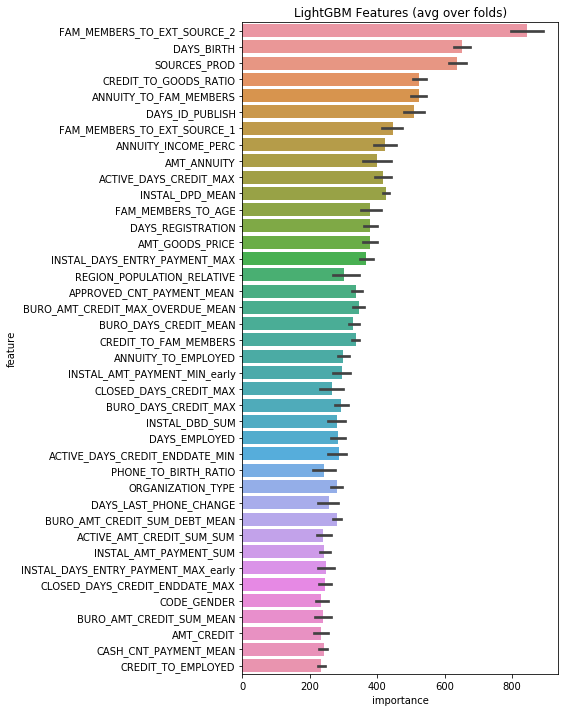

In [246]:
if __name__ == "__main__":
    submission_file_name = "submission_kernel05.csv"
    with timer("Full model run"):
        result = main(debug=False,
                      optimize_params=False, 
                      model='lightgbm', 
                      from_file=True)

In [240]:
topn = result[["feature", "importance"]].groupby("feature").mean()\
         .sort_values(by="importance", ascending=False)

In [241]:
topn.reset_index(inplace=True)
topn.to_csv('feature_importance_scores_no_onehot.csv', index=False)

In [ ]:
df = result
train_df = df[df['TARGET'].notnull()]
y = train_df['TARGET']
feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index', 'index_null_ind']]
train_df = train_df[feats].copy()
    
X_train, X_test, y_train, y_test = train_test_split(\
            train_df, y, test_size=0.33, random_state=42)

X_train.columns = [c.replace(' ', '_') for c in X_train.columns.values.tolist()]

#'FONDKAPREMONT_MODE_not_specified' in X_train.columns.values.tolist()
#sorted(X_train.columns.values.tolist())

In [218]:
res_gp = gp_minimize(objective, space, n_calls=20,
                     random_state=0, n_random_starts=10)

"Best score=%.4f" % res_gp.fun

KeyError: "['FONDKAPREMONT_MODE_not_specified' 'FONDKAPREMONT_MODE_org_spec_account'\n 'FONDKAPREMONT_MODE_reg_oper_account'\n 'FONDKAPREMONT_MODE_reg_oper_spec_account'\n 'HOUSETYPE_MODE_block_of_flats' 'HOUSETYPE_MODE_specific_housing'\n 'HOUSETYPE_MODE_terraced_house' 'NAME_CONTRACT_TYPE_Cash_loans'\n 'NAME_CONTRACT_TYPE_Revolving_loans'\n 'NAME_EDUCATION_TYPE_Academic_degree'\n 'NAME_EDUCATION_TYPE_Higher_education'\n 'NAME_EDUCATION_TYPE_Incomplete_higher'\n 'NAME_EDUCATION_TYPE_Lower_secondary'\n 'NAME_EDUCATION_TYPE_Secondary_/_secondary_special'\n 'NAME_FAMILY_STATUS_Civil_marriage'\n 'NAME_FAMILY_STATUS_Single_/_not_married'\n 'NAME_HOUSING_TYPE_Co-op_apartment' 'NAME_HOUSING_TYPE_House_/_apartment'\n 'NAME_HOUSING_TYPE_Municipal_apartment'\n 'NAME_HOUSING_TYPE_Office_apartment' 'NAME_HOUSING_TYPE_Rented_apartment'\n 'NAME_HOUSING_TYPE_With_parents' 'NAME_INCOME_TYPE_Commercial_associate'\n 'NAME_INCOME_TYPE_State_servant' 'NAME_TYPE_SUITE_Group_of_people'\n 'NAME_TYPE_SUITE_Spouse,_partner' 'OCCUPATION_TYPE_Cleaning_staff'\n 'OCCUPATION_TYPE_Cooking_staff' 'OCCUPATION_TYPE_Core_staff'\n 'OCCUPATION_TYPE_HR_staff' 'OCCUPATION_TYPE_High_skill_tech_staff'\n 'OCCUPATION_TYPE_IT_staff' 'OCCUPATION_TYPE_Low-skill_Laborers'\n 'OCCUPATION_TYPE_Medicine_staff' 'OCCUPATION_TYPE_Private_service_staff'\n 'OCCUPATION_TYPE_Realty_agents' 'OCCUPATION_TYPE_Sales_staff'\n 'OCCUPATION_TYPE_Security_staff' 'OCCUPATION_TYPE_Waiters/barmen_staff'\n 'ORGANIZATION_TYPE_Business_Entity_Type_1'\n 'ORGANIZATION_TYPE_Business_Entity_Type_2'\n 'ORGANIZATION_TYPE_Business_Entity_Type_3'\n 'ORGANIZATION_TYPE_Industry:_type_1'\n 'ORGANIZATION_TYPE_Industry:_type_10'\n 'ORGANIZATION_TYPE_Industry:_type_11'\n 'ORGANIZATION_TYPE_Industry:_type_12'\n 'ORGANIZATION_TYPE_Industry:_type_13'\n 'ORGANIZATION_TYPE_Industry:_type_2' 'ORGANIZATION_TYPE_Industry:_type_3'\n 'ORGANIZATION_TYPE_Industry:_type_4' 'ORGANIZATION_TYPE_Industry:_type_5'\n 'ORGANIZATION_TYPE_Industry:_type_6' 'ORGANIZATION_TYPE_Industry:_type_7'\n 'ORGANIZATION_TYPE_Industry:_type_8' 'ORGANIZATION_TYPE_Industry:_type_9'\n 'ORGANIZATION_TYPE_Legal_Services'\n 'ORGANIZATION_TYPE_Security_Ministries' 'ORGANIZATION_TYPE_Trade:_type_1'\n 'ORGANIZATION_TYPE_Trade:_type_2' 'ORGANIZATION_TYPE_Trade:_type_3'\n 'ORGANIZATION_TYPE_Trade:_type_4' 'ORGANIZATION_TYPE_Trade:_type_5'\n 'ORGANIZATION_TYPE_Trade:_type_6' 'ORGANIZATION_TYPE_Trade:_type_7'\n 'ORGANIZATION_TYPE_Transport:_type_1'\n 'ORGANIZATION_TYPE_Transport:_type_2'\n 'ORGANIZATION_TYPE_Transport:_type_3'\n 'ORGANIZATION_TYPE_Transport:_type_4' 'WALLSMATERIAL_MODE_Stone,_brick'\n 'BURO_CREDIT_ACTIVE_Bad_debt_MEAN' 'BURO_CREDIT_CURRENCY_currency_1_MEAN'\n 'BURO_CREDIT_CURRENCY_currency_2_MEAN'\n 'BURO_CREDIT_CURRENCY_currency_4_MEAN'\n 'BURO_CREDIT_TYPE_Another_type_of_loan_MEAN'\n 'BURO_CREDIT_TYPE_Car_loan_MEAN' 'BURO_CREDIT_TYPE_Consumer_credit_MEAN'\n 'BURO_CREDIT_TYPE_Credit_card_MEAN'\n 'BURO_CREDIT_TYPE_Loan_for_business_development_MEAN'\n 'BURO_CREDIT_TYPE_Loan_for_working_capital_replenishment_MEAN'\n 'BURO_CREDIT_TYPE_Real_estate_loan_MEAN'\n 'BURO_CREDIT_TYPE_Unknown_type_of_loan_MEAN'\n 'PREV_NAME_CONTRACT_TYPE_Cash_loans_MEAN'\n 'PREV_NAME_CONTRACT_TYPE_Consumer_loans_MEAN'\n 'PREV_NAME_CONTRACT_TYPE_Revolving_loans_MEAN'\n 'PREV_NAME_CASH_LOAN_PURPOSE_Building_a_house_or_an_annex_MEAN'\n 'PREV_NAME_CASH_LOAN_PURPOSE_Business_development_MEAN'\n 'PREV_NAME_CASH_LOAN_PURPOSE_Buying_a_garage_MEAN'\n 'PREV_NAME_CASH_LOAN_PURPOSE_Buying_a_holiday_home_/_land_MEAN'\n 'PREV_NAME_CASH_LOAN_PURPOSE_Buying_a_home_MEAN'\n 'PREV_NAME_CASH_LOAN_PURPOSE_Buying_a_new_car_MEAN'\n 'PREV_NAME_CASH_LOAN_PURPOSE_Buying_a_used_car_MEAN'\n 'PREV_NAME_CASH_LOAN_PURPOSE_Car_repairs_MEAN'\n 'PREV_NAME_CASH_LOAN_PURPOSE_Everyday_expenses_MEAN'\n 'PREV_NAME_CASH_LOAN_PURPOSE_Gasification_/_water_supply_MEAN'\n 'PREV_NAME_CASH_LOAN_PURPOSE_Payments_on_other_loans_MEAN'\n 'PREV_NAME_CASH_LOAN_PURPOSE_Purchase_of_electronic_equipment_MEAN'\n 'PREV_NAME_CASH_LOAN_PURPOSE_Urgent_needs_MEAN'\n 'PREV_NAME_CASH_LOAN_PURPOSE_Wedding_/_gift_/_holiday_MEAN'\n 'PREV_NAME_CONTRACT_STATUS_Unused_offer_MEAN'\n 'PREV_NAME_PAYMENT_TYPE_Cash_through_the_bank_MEAN'\n 'PREV_NAME_PAYMENT_TYPE_Cashless_from_the_account_of_the_employer_MEAN'\n 'PREV_NAME_PAYMENT_TYPE_Non-cash_from_your_account_MEAN'\n 'PREV_NAME_TYPE_SUITE_Group_of_people_MEAN'\n 'PREV_NAME_TYPE_SUITE_Spouse,_partner_MEAN'\n 'PREV_NAME_GOODS_CATEGORY_Auto_Accessories_MEAN'\n 'PREV_NAME_GOODS_CATEGORY_Clothing_and_Accessories_MEAN'\n 'PREV_NAME_GOODS_CATEGORY_Construction_Materials_MEAN'\n 'PREV_NAME_GOODS_CATEGORY_Consumer_Electronics_MEAN'\n 'PREV_NAME_GOODS_CATEGORY_Direct_Sales_MEAN'\n 'PREV_NAME_GOODS_CATEGORY_Medical_Supplies_MEAN'\n 'PREV_NAME_GOODS_CATEGORY_Office_Appliances_MEAN'\n 'PREV_NAME_GOODS_CATEGORY_Photo_/_Cinema_Equipment_MEAN'\n 'PREV_NAME_GOODS_CATEGORY_Sport_and_Leisure_MEAN'\n 'PREV_CHANNEL_TYPE_AP+_(Cash_loan)_MEAN'\n 'PREV_CHANNEL_TYPE_Car_dealer_MEAN'\n 'PREV_CHANNEL_TYPE_Channel_of_corporate_sales_MEAN'\n 'PREV_CHANNEL_TYPE_Contact_center_MEAN'\n 'PREV_CHANNEL_TYPE_Credit_and_cash_offices_MEAN'\n 'PREV_CHANNEL_TYPE_Regional_/_Local_MEAN'\n 'PREV_NAME_SELLER_INDUSTRY_Auto_technology_MEAN'\n 'PREV_NAME_SELLER_INDUSTRY_Consumer_electronics_MEAN'\n 'PREV_NAME_SELLER_INDUSTRY_MLM_partners_MEAN'\n 'PREV_PRODUCT_COMBINATION_Card_Street_MEAN'\n 'PREV_PRODUCT_COMBINATION_Card_X-Sell_MEAN'\n 'PREV_PRODUCT_COMBINATION_Cash_Street:_high_MEAN'\n 'PREV_PRODUCT_COMBINATION_Cash_Street:_low_MEAN'\n 'PREV_PRODUCT_COMBINATION_Cash_Street:_middle_MEAN'\n 'PREV_PRODUCT_COMBINATION_Cash_X-Sell:_high_MEAN'\n 'PREV_PRODUCT_COMBINATION_Cash_X-Sell:_low_MEAN'\n 'PREV_PRODUCT_COMBINATION_Cash_X-Sell:_middle_MEAN'\n 'PREV_PRODUCT_COMBINATION_POS_household_with_interest_MEAN'\n 'PREV_PRODUCT_COMBINATION_POS_household_without_interest_MEAN'\n 'PREV_PRODUCT_COMBINATION_POS_industry_with_interest_MEAN'\n 'PREV_PRODUCT_COMBINATION_POS_industry_without_interest_MEAN'\n 'PREV_PRODUCT_COMBINATION_POS_mobile_with_interest_MEAN'\n 'PREV_PRODUCT_COMBINATION_POS_mobile_without_interest_MEAN'\n 'PREV_PRODUCT_COMBINATION_POS_other_with_interest_MEAN'\n 'PREV_PRODUCT_COMBINATION_POS_others_without_interest_MEAN'\n 'POS_NAME_CONTRACT_STATUS_Returned_to_the_store_MEAN'\n 'CC_NAME_CONTRACT_STATUS_Sent_proposal_MIN'\n 'CC_NAME_CONTRACT_STATUS_Sent_proposal_MAX'\n 'CC_NAME_CONTRACT_STATUS_Sent_proposal_MEAN'\n 'CC_NAME_CONTRACT_STATUS_Sent_proposal_SUM'\n 'CC_NAME_CONTRACT_STATUS_Sent_proposal_VAR'] not in index"

In [221]:
ORGANIZATION_TYPE_Industry:_type_7

True

In [78]:
avg_importance = feat_importance.groupby(['feature'])['importance'].mean()
#avg_importance.sort_values(ascending=False)
sum(avg_importance > 0.0)

311